# Assignment 3

**Deadline**:  15/10/2024, 17:00

**Names and student numbers:**
1. name (student number)
2. ...
3. ...

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
4. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together. Before you submit, you and your team members have to register as an **Assignment group** on Canvas. Only a single member of each group has to submit the notebook. Please do **NOT** submit the same notebook multiple times!
5. Please write your names also inside this markdown cell, under **Names and student numbers**.

**Exercise:** import the relevant libraries.

In [1]:
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FactorAnalysis



# Instructions
In this assignment you have to develop a regression model. You will be given a training set of 800 datapoints. Using the techniques presented in this course, we ask you to come up with a model that has the best generalization performance. This performance will be assessed on a test dataset of 16,000 datapoints, which is not available to you. The assignment is also a competition: your mark depends (partly) on how well your model does compared to those of other groups and the three groups with the best performing model will be announced on Canvas.

### The data
The training data can be found in the file “training_data.csv” on Canvas. It consists of a two-dimensional comma-separated matrix of 800 rows and 27 columns. Each row is a datapoint, consisting of 26 input variables and 1 target variable. The target variable is the last column of the matrix.

### Submitting your work
Your work in this Jupyter notebook consists of two parts. **Part 1** is used to train, create and evaluate your best performing model. In the first cell, you have to train your best performing model on the training data. The code to load the training data is already given. Furthermore, in that same cell you have to create a function called `best_model`. This function has a single input argument, which is a 2-dimensional NumPy array with an arbitrary number of rows and 26 columns (e.g. the input features `X` of the training data). The function should return a 1-dimensional array with the predictions of your best model for the datapoints in the input argument. Hence, the number of elements in this 1-dimensional array should be equal to the number of rows of the 2-dimensional array used as input argument.

In the second cell, we are using a testset called `test_data.csv` of 16,000 datapoints to assess the generalization performance of your function `best_model`. Of course, the testset is only available to the teachers. The code in the second cell may not be changed!!! It will be used by the teachers to compute the generalization performance of your best model. On Canvas, you can find a file called `FAKE_test_data.csv`. This is a 2-dimensional array of completely random numbers (fake data), having the same dimensions as the dataset in `test_data.csv`. If you put this file in the same folder as this Jupyter notebook, you can test whether your function `best_model` is defined correctly by checking if the second cell runs without errors. Since the numbers in `FAKE_test_data.csv` are fake data, they **cannot** be used to estimate the performance of your `best_model`. **AFTER TRAINING AND CREATING YOUR BEST MODEL IN THE FIRST CELL, THE SECOND CELL SHOULD RUN WITHOUT ERRORS!!!** If this is not the case, your work will **not** be marked. 

In **Part 2** of the notebook, you will present your analysis of the regression problem and the steps you have taken to arrive at your best model. Here, you have to explain and perform all the methods that you have used to identify your best model. As in all exercises, please make sure all steps are well motivated and presented in a clear and structured manner. We recommend using visualization methods (e.g., plots with matplotlib), if applicable, to clarify your work.

### Examples
On Canvas, you can find two example notebooks (“DSM_assignment3_example_with_sklearn.ipynb”, “DSM_assignment3_example_without_sklearn.ipynb”). These notebooks contain examples of how you can submit **Part 1** of the assignment. As "best model" in the examples, we have **arbitrarily** chosen for a regression model using the third power of the 7-th principal component. In one of the files we use scikit-learn, whereas in the other one we train the same model without using scikit-learn. Please look carefully at how the function `best_model` is created and make sure you understand all steps.

### Allowed methods
Any of the methods discussed in the course may be used. You are also allowed to combine different models and techniques. If you doubt whether your method is allowed, please consult with the teachers. 

Furthermore, you are allowed to use libraries like scikit-learn, but you are not required to use them.

### The competition
The generalization performance of your best model is assessed by the **root mean squared error (RMSE)** on a secret test dataset consisting of 16,000 independent and identically distributed datapoints. They were created with the same data-generating process as the data of the training set of 800 datapoints. The scores will be ranked and the top-three groups and their scores will be announced in class.

### The marking
As can be seen in the rubric on Canvas, 20% of your mark will depend on the generalization performance of your best model, compared to the best models of your peers. The other 80% is for the quality of your analysis and your code.

# Part 1: training, creating and evaluating your best model

In [8]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Loading the training data
training_data = np.genfromtxt("training_data.csv", delimiter=',')
X = training_data[:, :-1]
y = training_data[:, -1]

# Remove outliers where target variable y is greater than 75
mask = y <= 75
X = X[mask]
y = y[mask]

### Seting X_scaled to be equal to X, as we refer it in some chunks of code (Essentially it's the same)
X_scaled = X

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 1: PCA
pca = PCA(n_components=2)  # Start with 2 components
X_pca = pca.fit_transform(X)

# Step 2: K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add the cluster labels as an additional feature
X_pca_with_clusters = np.column_stack((X_pca, clusters))

# Define a global dictionary to store trained models for each cluster and RMSE results
trained_models = {}
results = {}

# Step 3: Running regressions for each cluster
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV

for cluster in range(2):
    # Select data for the current cluster
    X_cluster = X_pca_with_clusters[X_pca_with_clusters[:, -1] == cluster, :-1]
    y_cluster = y[X_pca_with_clusters[:, -1] == cluster]

    # Train different models and store them
    models = {
        'OLS': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }
    
    for name, model in models.items():
        # Perform 5-fold cross-validation and compute RMSE for each model
        fold_rmse = []
        
        for train_idx, val_idx in kfold.split(X_cluster):
            X_train, X_val = X_cluster[train_idx], X_cluster[val_idx]
            y_train, y_val = y_cluster[train_idx], y_cluster[val_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            fold_rmse.append(rmse)
        
        # Calculate average RMSE over all folds
        avg_rmse = np.mean(fold_rmse)
        
        # Store the trained model and its RMSE
        trained_models[(cluster, name)] = model
        results[(cluster, name)] = avg_rmse

# Step 4: Print RMSE results
for key, value in results.items():
    print(f"Cluster {key[0]}, Model {key[1]}: RMSE = {value:.4f}")

# Function for making predictions
def best_model(X_new):
    # Step 1: Transform the new data using PCA
    Z_new = pca.transform(X_new)

    # Step 2: Predict the clusters for the new data
    test_clusters = kmeans.predict(Z_new)

    # Prepare an array for predictions
    predictions = np.zeros(X_new.shape[0])

    # Step 3: Make predictions based on the cluster
    for i in range(len(test_clusters)):
        X_new_cluster = Z_new[i:i+1]  # Get the new data point as a 2D array

        # Select the appropriate model based on the predicted cluster
        if test_clusters[i] == 1:
            model = trained_models.get((1, 'Ridge'), None)  # Adjust as needed
        else:
            model = trained_models.get((0, 'KNN'), None)  # Adjust as needed

        # Check if a valid model was found
        if model is not None:
            # Make prediction for this data point
            predictions[i] = model.predict(X_new_cluster)[0]  # Get the first element from the array
        else:
            predictions[i] = np.nan  # Assign NaN if model not found

    return predictions


Cluster 0, Model OLS: RMSE = 5.6584
Cluster 0, Model Ridge: RMSE = 5.6892
Cluster 0, Model Lasso: RMSE = 5.7096
Cluster 0, Model KNN: RMSE = 5.4128
Cluster 1, Model OLS: RMSE = 1.1436
Cluster 1, Model Ridge: RMSE = 1.1957
Cluster 1, Model Lasso: RMSE = 1.2262
Cluster 1, Model KNN: RMSE = 1.2986


/Users/botak/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [3]:
######################################################
#    !!!DO NOT CHANGE THE CODE IN THIS CELL!!!       #
# THIS CELL IS USED FOR EVALUATING YOUR BEST MODEL.  #  
# AFTER TRAINING AND CREATING YOUR BEST MODEL IN THE #
# PREVIOUS CELL, THIS CELL SHOULD RUN WITHOUT ERRORS # 
######################################################

# Determining which test data will be used. If real test 
# data is available, it will be used. Otherwise, the 
# fake test data will be used.
if os.path.exists("test_data.csv"):
    test_data_filename = "test_data.csv"
elif os.path.exists("FAKE_test_data.csv"):
    test_data_filename = "FAKE_test_data.csv"
else:
    test_data_filename = None
    print("ERROR: Test data is missing!")
    
if test_data_filename:

    # loading the test data    
    test_data = np.genfromtxt(test_data_filename, delimiter=',')
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]

    # making predictions and computing the root mean squared error (RMSE)
    predictions = best_model(X_test)
    RMSE = np.sqrt(np.mean((predictions - y_test)**2))

    print("The RMSE is: ", RMSE)

The RMSE is:  11.601852618049017


# Part 2: analysis 

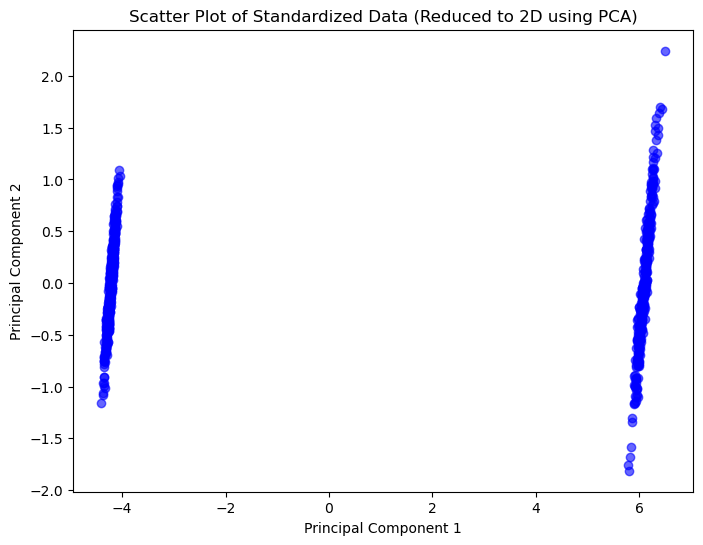

1


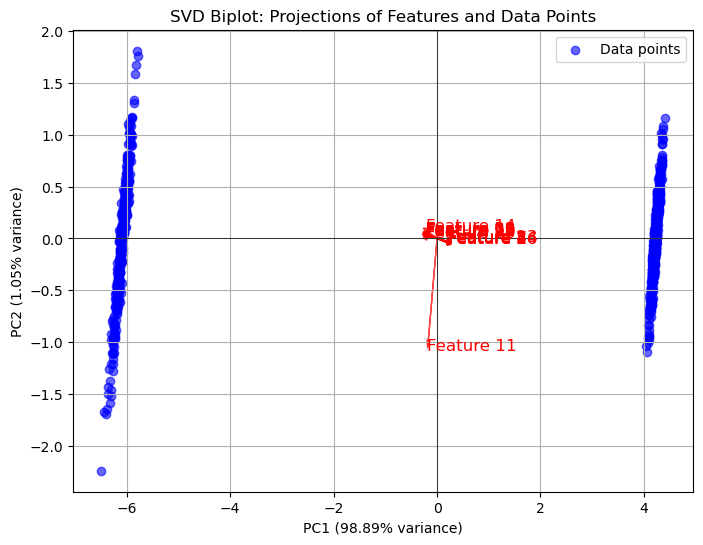

The optimal number of dimensions to retain is: 1


In [4]:
#THIS IS SCATTER PLOT OF THE DATA AFTER DOING PCA, SO WE CAN VIEW IT IN 2D WITH THE MOST IMPORTANT DIMENSIONS AND WE OBSERVE THAT DATA CAN BE SEPARATED IN 2 DIFFERENT CLUSTERS.
#WE SHOULD DEVELOP THIS IDEA. I WOULD SUGGEST TO PLOT THE DISTRIBUTION OF EACH CLUSTER SEPARATELY AND THEN SEE WHICH MODELS DO BEST DEPENDING ON HOW THE DATA LOOKS LIKE.
#WE CAN MIX RIDGE/LASSO WITH THE 26 FEATURES WITH ANOTHER MODEL LIKE LEAST SQUARES, OR WHATEVER MODEL THAT YOU MAY THINK CAN DO GOOD WITH THE DISTRIBUTION OF THE DATA.

# Scatter plot of the reduced 2D data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.6)
plt.title("Scatter Plot of Standardized Data (Reduced to 2D using PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### 



# Step 1: Standardize the data (feature-wise)
X_mean = np.mean(X, axis=0)  # Compute the mean for each feature (column)
X_std = np.std(X, axis=0)    # Compute the standard deviation for each feature (column)
X_standardized = (X - X_mean) / X_std  # Standardize each feature

# Step 2: Apply SVD on the standardized data
U, D, V_T = np.linalg.svd(X_standardized, full_matrices=False)
V = V_T.T
Z = X_standardized @ V

# Step 3: Compute variance explained by each component
variance_explained = (D ** 2) / np.sum(D ** 2)  # Individual variance explained
cumulative_variance_explained = np.cumsum(variance_explained)  # Cumulative variance explained

# Step 4: Determine the optimal k (e.g., retain 95% of the variance)
threshold = 0.90
k = np.argmax(cumulative_variance_explained >= threshold) + 1  # Optimal k
print(k)

###

#THIS IS A PLOT THAT SHOWS THE DISTRIBUTION OF THE DATAPOINTS AND HOW FEATURES AFFECT THE VARIANCE. FEATURE 11 IS THE ONLY ONE WHICH IS NOT CLOSE TO 0, BUT I CANT INTERPRET IT PROPERLY

# Assuming X_standardized is already standardized data
U, D, V_T = np.linalg.svd(X_standardized, full_matrices=False)
V = V_T.T  # V contains the directions of the principal components

# Project the data onto the first two principal components
Z = X_standardized @ V[:, :2]  # Z is the data in the 2D PCA space

# Create the biplot
plt.figure(figsize=(8, 6))
# Plot the projections of the data points
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.6, color='blue', label='Data points')

# Plot the directions of each feature (columns of V)
for i in range(V.shape[0]):
    plt.arrow(0, 0, V[i, 0], V[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(V[i, 0] * 1.1, V[i, 1] * 1.1, f"Feature {i+1}", color='red', fontsize=12)

# Label the axes with the variance explained by each principal component
variance_explained = (D ** 2) / np.sum(D ** 2)
plt.xlabel(f"PC1 ({variance_explained[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({variance_explained[1]*100:.2f}% variance)")
plt.title('SVD Biplot: Projections of Features and Data Points')
plt.grid()
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.legend()
plt.show()


####

#THIS IS LDA CLASSIFICATION IN ORDER TO SEE WHICH FEATURES EXPLAIN THE MOST OF THE DATASET
# Step 1: Standardize the data (feature-wise)
X_mean = np.mean(X, axis=0)  # Compute the mean for each feature (column)
X_std = np.std(X, axis=0)    # Compute the standard deviation for each feature (column)
X_standardized = (X - X_mean) / X_std  # Standardize each feature

# Step 2: Compute the means of each class and the overall mean
classes = np.unique(y)
n_features = X_standardized.shape[1]
mean_overall = np.mean(X_standardized, axis=0)

# Step 3: Compute the within-class scatter matrix (Sw) and between-class scatter matrix (Sb)
Sw = np.zeros((n_features, n_features))
Sb = np.zeros((n_features, n_features))

for c in classes:
    X_c = X_standardized[y == c]
    mean_c = np.mean(X_c, axis=0)
    Sw += np.dot((X_c - mean_c).T, (X_c - mean_c))
    n_c = X_c.shape[0]
    mean_diff = (mean_c - mean_overall).reshape(-1, 1)
    Sb += n_c * np.dot(mean_diff, mean_diff.T)

# Step 4: Solve the generalized eigenvalue problem for Sw^-1 * Sb
# Adding a small identity matrix to Sw for numerical stability in inversion
Sw += np.eye(n_features) * 1e-6
eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

# Take only the real part of the eigenvalues (to avoid complex numbers)
eigenvalues = np.real(eigenvalues)

# Step 5: Sort the eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Step 6: Calculate the variance explained
eigenvalue_sum = np.sum(eigenvalues)
variance_explained = eigenvalues / eigenvalue_sum
cumulative_variance_explained = np.cumsum(variance_explained)
threshold = 0.98
k = np.argmax(cumulative_variance_explained >= threshold) + 1

# Step 7: Project the data onto the first k eigenvectors
W = eigenvectors[:, :k]  # Select the top k eigenvectors
Z_lda = X_standardized @ W

print(f"The optimal number of dimensions to retain is: {k}")



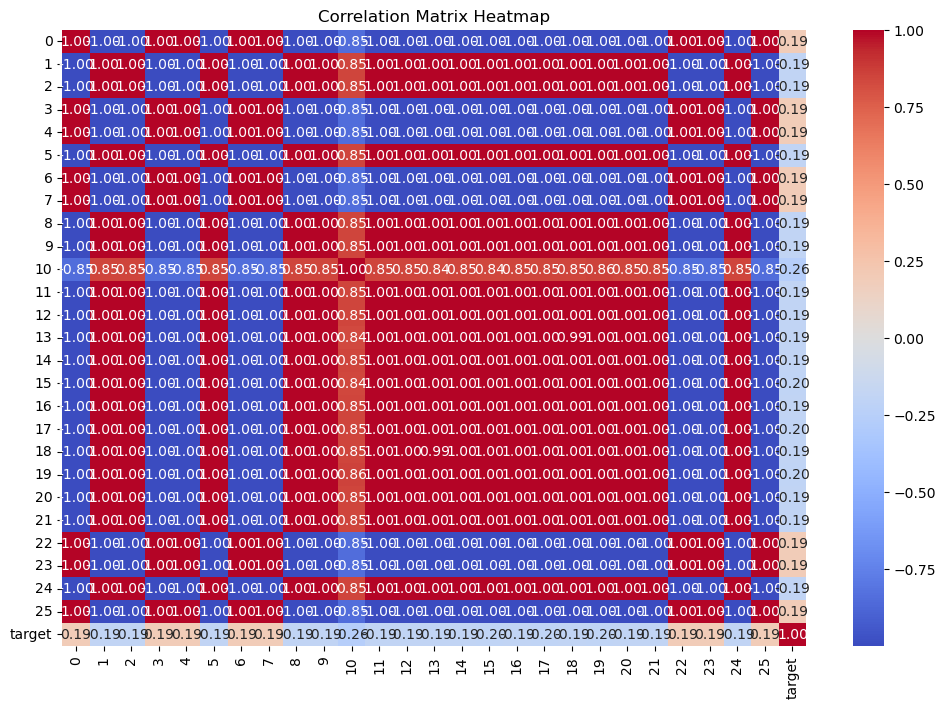

From the correlation matrix we observe that the majority of features are perfectly correlated (-1 or 1). This indicates that dimension reduction will simplify a lot.


In [5]:
### The Correlation Matrix
# Convert the data into a pandas DataFrame for easier visualization
df = pd.DataFrame(X)
df['target'] = y

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

print("From the correlation matrix we observe that the majority of features are perfectly correlated (-1 or 1). This indicates that dimension reduction will simplify a lot.")

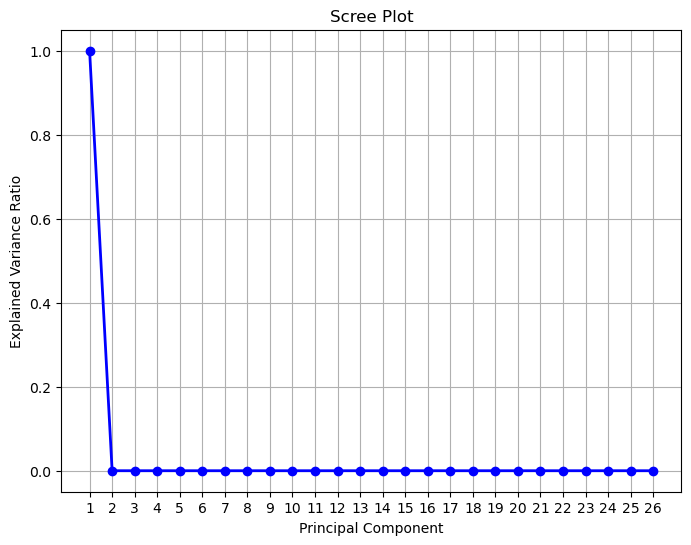

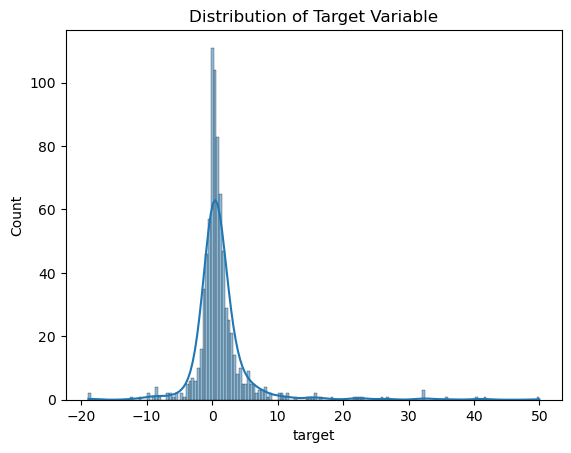

The target variable is normally distributed. This is a sign that a lot of regression models could be viable, even OLS.


In [6]:
# Scree plot to see how many principal components do we need 

# Fit PCA without specifying the number of components (to get all components)
pca = PCA()
pca.fit(X_scaled)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()
# Split the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# The distribution of the target variable
sns.histplot(df['target'], kde=True)
plt.title('Distribution of Target Variable')
plt.show()

print("The target variable is normally distributed. This is a sign that a lot of regression models could be viable, even OLS.")

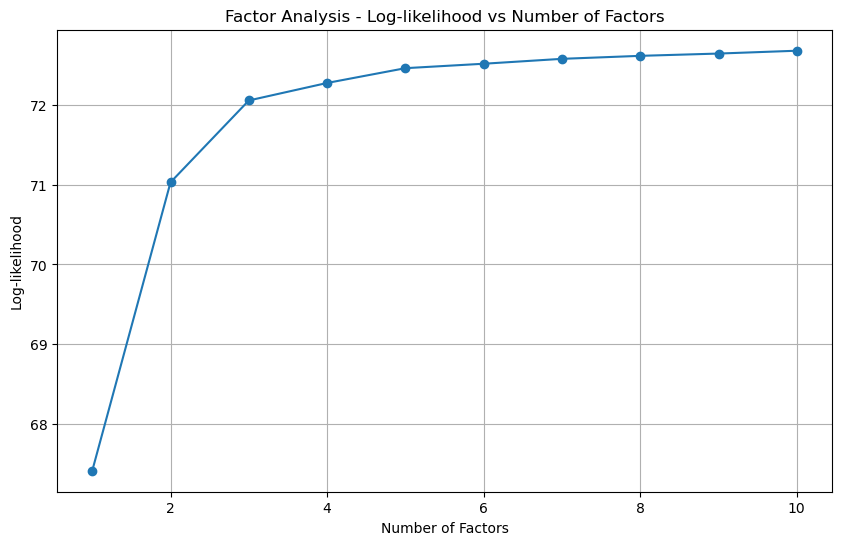

Based on the graph we can see that the optimal number of factors would be 3. However, we chose not to pursue the forecast using factor analysis. As factor analysis ignores unique variance, which may be important, it's sensitive to small samples, which could induce bias into the forecasts.


In [7]:
## Additionally to PCA we were considering using Factor Analysis.

# Apply Factor Analysis for a range of components (e.g., 1 to 10 factors)
n_factors = np.arange(1, 11)
fa_models = [FactorAnalysis(n_components=n).fit(X) for n in n_factors]

# Calculate the log-likelihood for each model (higher is better)
log_likelihoods = [model.score(X) for model in fa_models]

# Plot the log-likelihood as a function of the number of factors
plt.figure(figsize=(10, 6))
plt.plot(n_factors, log_likelihoods, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Log-likelihood')
plt.title('Factor Analysis - Log-likelihood vs Number of Factors')
plt.grid(True)
plt.show()

print("Based on the graph we can see that the optimal number of factors would be 3. However, we chose not to pursue the forecast using factor analysis. As factor analysis ignores unique variance, which may be important, it's sensitive to small samples, which could induce bias into the forecasts.")

